In [1]:
import pandas as pd
"""torch"""

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
"""core"""
import csv, gc, gzip, os, pickle, shutil, sys, warnings, yaml, io, subprocess
import math, matplotlib.pyplot as plt, numpy as np, pandas as pd, random
import scipy.stats, scipy.special
import abc, collections, hashlib, itertools, json, operator, pathlib
import mimetypes, inspect, typing, functools, importlib, weakref
import html, re, requests, tarfile, numbers, tempfile

from abc import abstractmethod, abstractproperty
from collections import abc,  Counter, defaultdict, Iterable, namedtuple, OrderedDict
import concurrent
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from copy import copy, deepcopy
from dataclasses import dataclass, field, InitVar
from enum import Enum, IntEnum
from functools import partial, reduce
from pdb import set_trace
from matplotlib import patches, patheffects
from numpy import array, cos, exp, log, sin, tan, tanh
from operator import attrgetter, itemgetter
from pathlib import Path
from warnings import warn
from contextlib import contextmanager
from fastprogress.fastprogress import MasterBar, ProgressBar
from matplotlib.patches import Patch
from pandas import Series, DataFrame
from io import BufferedWriter, BytesIO

import pkg_resources
pkg_resources.require("fastprogress>=0.1.19")
from fastprogress.fastprogress import master_bar, progress_bar

#for type annotations
from numbers import Number
from typing import Any, AnyStr, Callable, Collection, Dict, Hashable, Iterator, List, Mapping, NewType, Optional
from typing import Sequence, Tuple, TypeVar, Union
from types import SimpleNamespace

def try_import(module):
    "Try to import `module`. Returns module's object on success, None on failure"
    try: return importlib.import_module(module)
    except: return None

def have_min_pkg_version(package, version):
    "Check whether we have at least `version` of `package`. Returns True on success, False otherwise."
    try:
        pkg_resources.require(f"{package}>={version}")
        return True
    except:
        return False
    
    
"""Structured"""


from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz

def set_plot_sizes(sml, med, big):
    plt.rc('font', size=sml)          # controls default text sizes
    plt.rc('axes', titlesize=sml)     # fontsize of the axes title
    plt.rc('axes', labelsize=med)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('legend', fontsize=sml)    # legend fontsize
    plt.rc('figure', titlesize=big)  # fontsize of the figure title

def parallel_trees(m, fn, n_jobs=8):
        return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    
    
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

def combine_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
              seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

def get_sample(df,n):
    
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def add_datepart(df, fldname, drop=True, time=False, errors="raise"):	
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

def is_date(x): return np.issubdtype(x.dtype, np.datetime64)

def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):

    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

def get_nn_mappers(df, cat_vars, contin_vars):
   
    for v in contin_vars: df[v] = df[v].fillna(df[v].max()+100,)
    for v in cat_vars: df[v].fillna('#NA#', inplace=True)

    cat_maps = [(o, LabelEncoder()) for o in cat_vars]
    contin_maps = [([o], StandardScaler()) for o in contin_vars]

ModuleNotFoundError: No module named 'dataclasses'

In [2]:
full_data = pd.read_csv("For_modeling.csv",
                      index_col=0)

C:\Users\Sathishkumar V E\Anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
full_data.columns

Index(['Duration', 'Distance', 'PLong', 'PLatd', 'DLong', 'DLatd', 'Haversine',
       'Pmonth', 'Pday', 'Phour', 'Pmin', 'PDweek', 'Dmonth', 'Dday', 'Dhour',
       'Dmin', 'DDweek', 'Temp', 'Precip', 'Wind', 'Humid', 'Solar', 'Snow',
       'GroundTemp', 'Dust'],
      dtype='object')

In [17]:
cor=full_data[['Duration', 'Distance', 'PLong', 'PLatd', 'DLong', 'DLatd', 'Haversine',
       'Temp', 'Precip', 'Wind', 'Humid', 'Solar', 'Snow', 'GroundTemp', 'Dust']]

In [18]:
# Read packages into Python library
import pandas as pd
import numpy as np

In [19]:

# Create and print correlation matrix:
corr = cor.corr()
print(corr)

            Duration  Distance     PLong     PLatd     DLong     DLatd  \
Duration    1.000000  0.739233 -0.049251 -0.003411 -0.043889 -0.003776   
Distance    0.739233  1.000000 -0.050252 -0.013090 -0.042184 -0.012521   
PLong      -0.049251 -0.050252  1.000000  0.127341  0.929560  0.128974   
PLatd      -0.003411 -0.013090  0.127341  1.000000  0.130734  0.962225   
DLong      -0.043889 -0.042184  0.929560  0.130734  1.000000  0.130640   
DLatd      -0.003776 -0.012521  0.128974  0.962225  0.130640  1.000000   
Haversine   0.352915  0.579833 -0.036078  0.009455 -0.024832  0.010437   
Temp        0.128204  0.097193 -0.004360  0.002749 -0.001338  0.003744   
Precip     -0.009453 -0.008845 -0.001140 -0.003976 -0.001546 -0.003889   
Wind        0.072325  0.031359 -0.003288 -0.004997 -0.001217 -0.002734   
Humid      -0.096916 -0.034934  0.003820 -0.000987  0.003300 -0.002828   
Solar       0.072224 -0.003397  0.007705 -0.004832  0.002738 -0.004408   
Snow       -0.016298 -0.015968 -0.0031

In [20]:
# Limit number of digits:
corr.style.background_gradient(cmap='coolwarm').set_precision(1)

,Duration,Distance,PLong,PLatd,DLong,DLatd,Haversine,Temp,Precip,Wind,Humid,Solar,Snow,GroundTemp,Dust
Duration,1,0.7,-0.05,-0.003,-0.04,-0.004,0.4,0.1,-0.009,0.07,-0.1,0.07,-0.02,0.1,-0.02
Distance,0.7,1,-0.05,-0.01,-0.04,-0.01,0.6,0.1,-0.009,0.03,-0.03,-0.003,-0.02,0.07,-0.04
PLong,-0.05,-0.05,1,0.1,0.9,0.1,-0.04,-0.004,-0.001,-0.003,0.004,0.008,-0.003,0.0004,0.005
PLatd,-0.003,-0.01,0.1,1,0.1,1,0.009,0.003,-0.004,-0.005,-0.001,-0.005,-0.004,4e-05,-0.003
DLong,-0.04,-0.04,0.9,0.1,1,0.1,-0.02,-0.001,-0.002,-0.001,0.003,0.003,-0.003,0.0007,0.004
DLatd,-0.004,-0.01,0.1,1,0.1,1,0.01,0.004,-0.004,-0.003,-0.003,-0.004,-0.004,0.0009,-0.002
Haversine,0.4,0.6,-0.04,0.009,-0.02,0.01,1,0.03,-0.005,0.002,0.007,-0.04,-0.01,0.002,-0.02
Temp,0.1,0.1,-0.004,0.003,-0.001,0.004,0.03,1,0.01,0.08,0.08,0.3,-0.1,0.9,-0.2
Precip,-0.009,-0.009,-0.001,-0.004,-0.002,-0.004,-0.005,0.01,1,-0.01,0.1,-0.03,0.01,0.003,-0.03
Wind,0.07,0.03,-0.003,-0.005,-0.001,-0.003,0.002,0.08,-0.01,1,-0.3,0.3,-0.01,0.2,0.1


In [28]:
noweather=full_data[[
        'Duration', 'PLong', 'PLatd', 'DLong', 'DLatd', 'Haversine',
       'Pmonth', 'Pday', 'Phour', 'Pmin', 'PDweek', 'Dmonth', 'Dday', 'Dhour',
       'Dmin', 'DDweek']]
        

In [29]:
noweather.columns

Index(['Duration', 'PLong', 'PLatd', 'DLong', 'DLatd', 'Haversine', 'Pmonth',
       'Pday', 'Phour', 'Pmin', 'PDweek', 'Dmonth', 'Dday', 'Dhour', 'Dmin',
       'DDweek'],
      dtype='object')

In [30]:
df, y, nas = proc_df(noweather, 'Duration')

In [31]:
from sklearn.model_selection import train_test_split
X = df
Y = y
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=123)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((7200854, 15), (2400285, 15), (7200854,), (2400285,))

In [33]:
m = RandomForestRegressor()
m.fit(X_train, Y_train)
print_score(m)

C:\Users\Sathishkumar V E\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[1.6303793760823992, 3.6078171292685175, 0.9957585130085491, 0.9792922194631585, 0.20000000000000018, 0.5999999999999996, 0.5862110478211587, 1.4123581643473477]


In [32]:
from sklearn.linear_model import LinearRegression
lModel = LinearRegression()
lModel.fit(X_train,Y_train)
print_score(lModel)

[23.04443331959435, 23.070752861409186, 0.15263043898968964, 0.1532249460535947, 12.81628531321445, 12.811718214809503, 16.516036335187902, 16.52687041927414]


In [26]:
from sklearn.neighbors import KNeighborsRegressor
knnr = KNeighborsRegressor()
knnr.fit(X_train,Y_train)
print_score(knnr)

NameError: name 'KNeighborsRegressor' is not defined

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor()
GBR.fit(X_train,Y_train)
print_score(GBR)

In [18]:
full_data.isnull().sum()

Duration      0
Distance      0
PLong         0
PLatd         0
DLong         0
DLatd         0
Haversine     0
Pmonth        0
Pday          0
Phour         0
Pmin          0
PDweek        0
Dmonth        0
Dday          0
Dhour         0
Dmin          0
DDweek        0
Temp          0
Precip        0
Wind          0
Humid         0
Solar         0
Snow          0
GroundTemp    0
Dust          0
dtype: int64

In [8]:
full_data.columns

Index(['Duration', 'Distance', 'PLong', 'PLatd', 'DLong', 'DLatd', 'Haversine',
       'Pmonth', 'Pday', 'Phour', 'Pmin', 'PDweek', 'Dmonth', 'Dday', 'Dhour',
       'Dmin', 'DDweek', 'Temp', 'Precip', 'Wind', 'Humid', 'Solar', 'Snow',
       'GroundTemp', 'Dust'],
      dtype='object')

In [9]:
df_raw=full_data

In [10]:
df_raw.columns

Index(['Duration', 'Distance', 'PLong', 'PLatd', 'DLong', 'DLatd', 'Haversine',
       'Pmonth', 'Pday', 'Phour', 'Pmin', 'PDweek', 'Dmonth', 'Dday', 'Dhour',
       'Dmin', 'DDweek', 'Temp', 'Precip', 'Wind', 'Humid', 'Solar', 'Snow',
       'GroundTemp', 'Dust'],
      dtype='object')

In [11]:
from sklearn.utils import check_array

In [12]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())
from sklearn.metrics import median_absolute_error

def print_score(m):
    res = [rmse(m.predict(X_train), Y_train),rmse(m.predict(X_test), Y_test),
           m.score(X_train, Y_train),m.score(X_test, Y_test),
           median_absolute_error(m.predict(X_train), Y_train),median_absolute_error(m.predict(X_test), Y_test),
           metrics.mean_absolute_error(m.predict(X_train), Y_train),metrics.mean_absolute_error(m.predict(X_test), Y_test),
          
          ]
    

    print(res)

In [13]:
df, y, nas = proc_df(df_raw, 'Duration')

In [ ]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

C:\Users\Sathishkumar V E\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [11]:
df.shape

(9601139, 24)

In [14]:
from sklearn.model_selection import train_test_split
X = df
Y = y
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=123)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((7200854, 24), (2400285, 24), (7200854,), (2400285,))

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
lModel = LinearRegression()
lModel.fit(X_train,Y_train)
print_score(lModel)

[16.45886488845118, 16.481389449929672, 0.5677444744131879, 0.5678523409640224, 6.905972718524993, 6.908170860202411, 10.119534052035402, 10.127076921937325]


In [17]:
lModel

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,n_jobs=-1)
m.fit(X_train, Y_train)
print_score(m)

[4.331174479128638, 7.271350956031547, 0.9700668685930527, 0.9158847510681293, 1.0492302489177492, 1.9632440476190496, 2.148957077239548, 3.874116323578044]


In [15]:
m = RandomForestRegressor()
m.fit(X_train, Y_train)
print_score(m)

C:\Users\Sathishkumar V E\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[2.7621656876541736, 6.2566613880723345, 0.9878258052318115, 0.9377226930353788, 0.4000000000000057, 1.2000000000000002, 1.214925612111045, 2.9272624659021056]


In [29]:
m

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [16]:
from sklearn.neighbors import KNeighborsRegressor

In [17]:
knnr = KNeighborsRegressor()
knnr.fit(X_train,Y_train)
print_score(knnr)

[11.290051794363954, 13.93889654380706, 0.7966085642527805, 0.6908983590097277, 2.0, 2.5999999999999996, 5.531114587242021, 6.832913424864136]


In [31]:
knnr

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor()
GBR.fit(X_train,Y_train)
print_score(GBR)

[12.553292871904, 12.585133618096341, 0.748547408578075, 0.7480234165666263, 3.7455903394698495, 3.7568582590226693, 7.3586748067992644, 7.375745102866833]


In [32]:
GBR

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [34]:
from sklearn.tree import DecisionTreeRegressor

In [35]:
DTR = DecisionTreeRegressor()
DTR.fit(X_train,Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [37]:
print_score(DTR)

[0.019714809311246823, 8.65793830389747, 0.9999993798082926, 0.8807458517982193, 0.0, 1.0, 0.00036323074636308053, 3.482813587723879]


In [38]:
from sklearn.ensemble import AdaBoostRegressor
AdaBoost = AdaBoostRegressor()
AdaBoost.fit(X_train,Y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [40]:
print_score(AdaBoost)

[17.893769427777958, 17.910063965120724, 0.4890899246759892, 0.4896844581886513, 12.741028298302508, 12.741028298302508, 14.900777444304232, 14.906757157536026]


In [45]:
from xgboost import XGBRegressor

In [46]:
xgbr = XGBRegressor()
xgbr.fit(X_train,Y_train)

[07:21:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:21:46] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [47]:
print_score(xgbr)

[12.637856735478605, 12.669134050776561, 0.7451482330028836, 0.7446485172303899, 3.734848976135254, 3.742818832397461, 7.384161269923829, 7.401656778097418]


In [43]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(7,4), legend=False)

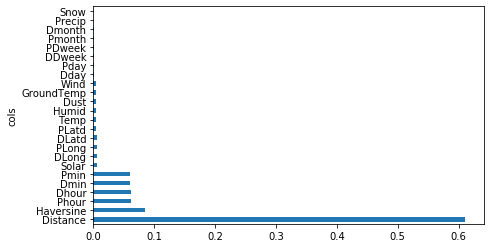

In [44]:
fi = rf_feat_importance(m, df)
plot_fi(fi[:30]);

In [57]:
mod1 = KNeighborsRegressor()
mod2 = XGBRegressor()
mod3 = RandomForestRegressor()
lr = RandomForestRegressor()

In [58]:
from mlxtend.regressor import StackingRegressor
sr = StackingRegressor(regressors=[mod1, mod2,mod3 ,lr], 
                          meta_regressor=lr)

In [59]:
sr.fit(X_train,Y_train)

[03:28:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:28:33] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


OSError: [WinError -529697949] Windows Error 0xe06d7363

In [ ]:
print_score(sr)

In [19]:

from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(dataset.data, dataset.target)
# display the relative importance of each attribute
print(model.feature_importances_)

NameError: name 'dataset' is not defined

In [6]:
a=['Distance', 
   'PLong', 'PLatd', 
   'DLong', 'DLatd', 
   'Haversine',
    'Pmonth', 'Pday', 'Phour', 'Pmin', 'PDweek',
   
   'Temp', 'Precip', 'Wind', 'Humid', 'Solar', 'Snow', 'Dust'
  ]

In [7]:
train=full_data[a]

In [8]:
train.isnull().sum()

Distance     0
PLong        0
PLatd        0
DLong        0
DLatd        0
Haversine    0
Pmonth       0
Pday         0
Phour        0
Pmin         0
PDweek       0
Temp         0
Precip       0
Wind         0
Humid        0
Solar        0
Snow         0
Dust         0
dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = train
Y = target
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=123)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint as sp_randint

In [12]:
from sklearn import linear_model
linreg_model = linear_model.LinearRegression()

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601139 entries, 0 to 9830310
Data columns (total 18 columns):
Distance     int64
PLong        float64
PLatd        float64
DLong        float64
DLatd        float64
Haversine    float64
Pmonth       int64
Pday         int64
Phour        int64
Pmin         int64
PDweek       int64
Temp         float64
Precip       float64
Wind         float64
Humid        float64
Solar        float64
Snow         float64
Dust         float64
dtypes: float64(12), int64(6)
memory usage: 1.4 GB


In [14]:
lparams={'fit_intercept':[True], 'n_jobs':[None], 'normalize':[False]}

In [15]:
LM = GridSearchCV(linreg_model, cv=10,param_grid=lparams)
LM.fit(X_train,Y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=None,
             param_grid={'fit_intercept': [True], 'n_jobs': [None],
                         'normalize': [False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
import numpy as np
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [20]:
preds = LM.predict(X_train)

In [ ]:
rmse(Y_train,X_train)

In [33]:
np.where(np.isnan(train))

(array([ 274510,  274511,  274512, ..., 8217407, 8217458, 8218923],
       dtype=int64), array([24, 24, 24, ..., 24, 24, 24], dtype=int64))